In [1]:
# import sys/os
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-2])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# Overview

In the following demo we illustrate how to compute the gradient of the Cauchy-Green strain tensor $ \mathbf{C}_{t_0}^t(\mathbf{x}_0) $ on a general three dimensional steady/unsteady velocity dataset. Particle trajectories $ \mathbf{x}(t;t_0,\mathbf{x_0}) $ launched from the initial position $ \mathbf{x}_0 $ at time $ t_0 $ satisfy the following ODE:

\begin{equation}
\mathbf{\dot{x}}(t) = \mathbf{v}(\mathbf{x}, t) \tag{1}
\end{equation}

The time-dependent velocity field $ \mathbf{v}(\mathbf{x}, t) $ is given on a gridded domain ($ X, Y, Z $). In this demo we choose the unsteady, viscous ABC flow. This notebook is structured as follows:

1. Import data from the file 'ABCunsteady.mat' stored in the folder 'data/ABC'.
2. Define computational parameters and data.
3. Interpolate velocity from (discrete) gridded data.
4. Compute gradient of the flow map $ \mathbf{\nabla F}_{t_0}^t(\mathbf{x}_0) $.
5. Compute Cauchy-Green strain tensor $ \mathbf{C}_{t_0}^t(\mathbf{x}_0) $ over the time-interval [$t_0, t$] at $ \mathbf{x}_0 $. Cauchy-Green strain tensor is defined as:

    \begin{equation}
    \mathbf{C}_{t_0}^t(\mathbf{x}_0)= [\mathbf{\nabla F}_{t_0}^t(\mathbf{x}_0)]^T\mathbf{\nabla F}_{t_0}^t(\mathbf{x}_0), i = {1,2} \tag{2}
    \end{equation}
 
    The eigenvectors of $ \mathbf{C}_{t_0}^t(\mathbf{x}_0) $ represent the initially most stretching($ \mathbf{\xi_3} $)/compressive($ \mathbf{\xi_1} $) and neutrally stretching ($ \mathbf{\xi_2} $) directions of a material element initially located at $ \mathbf{x}_0 $.

    They respectively solve the eigenvalue problem:
    
    \begin{equation}
    \mathbf{C}_{t_0}^t(\mathbf{x}_0) \mathbf{\xi}_i = \lambda_i\mathbf{\xi}_i, \tag{3}
    \end{equation}
    
    where $ \lambda_i $ corresponds to the corresponding stretching/compression value.

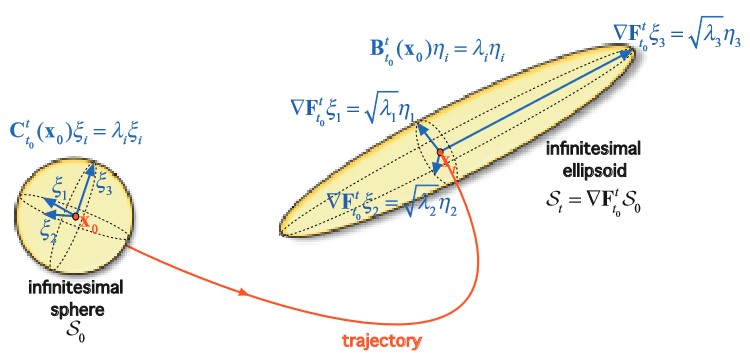

# Import data

In [2]:
# import scipy
import scipy.io as sio

# Import velocity data from file in data-folder
mat_file = sio.loadmat('../../data/ABC/ABCunsteady.mat')

U = mat_file['u'] # array (NY, NX, NZ)
V = mat_file['v'] # array (NY, NX, NZ)
W = mat_file['w'] # array (NY, NX, NZ)
x = mat_file['x'] # array (1, NX)
y = mat_file['y'] # array (1, NY)
z = mat_file['z'] # array (1, NZ)
time_data = mat_file['t']

# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
# import numpy
import numpy as np

# Number of cores for parallel computing
Ncores = 10 # int

# Periodic boundary conditions
periodic_x = True # bool
periodic_y = True # bool
periodic_z = True # bool
periodic = [periodic_x, periodic_y, periodic_z]

# Unsteady velocity field
bool_unsteady = True # bool

# Defined domain
defined_domain = np.isfinite(U).astype(int) # array (NY, NX, NZ)

## Compute meshgrid of dataset
X, Y, Z = np.meshgrid(x, y, z) # array (NY, NX), array (NY, NX, NZ)

## Resolution of meshgrid
dx_data = X[0,1,0]-X[0,0,0] # float
dy_data = Y[1,0,0]-Y[0,0,0] # float
dz_data = Y[0,0,1]-Z[0,0,0] # float

delta = [dx_data, dy_data, dx_data] # list (3, )

# Interpolate velocity

In order to evaluate the velocity field at arbitrary locations and times, we interpolate the discrete velocity data. The interpolation with respect to time is always linear. The interpolation with respect to space can be chosen to be "cubic" or "linear". Default value is "cubic".

In [4]:
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_unsteady

# Set nan values to zero (in case there are any) so that we can apply interpolant. 
# Interpolant does not work if the array contains nan values. 
U[np.isnan(U)] = 0
V[np.isnan(V)] = 0
W[np.isnan(W)] = 0

# Interpolate velocity data using cubic spatial interpolation
Interpolant = interpolant_unsteady(X, Y, Z, U, V, W, time_data)

Interpolant_u = Interpolant[0] # RectangularBivariateSpline-object
Interpolant_v = Interpolant[1] # RectangularBivariateSpline-object
Interpolant_w = Interpolant[2] # RectangularBivariateSpline-object

# IMPORTANT: We assume that the velocity field is on a gridded and evenly spaced domain. 
# We also assume for unsteady velocity fields, that the time is evenly spaced.

# Compute gradient of the flow map

In [5]:
# Import function to compute gradient of flow map
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# import package used to suppress output of integration of flow map. 
from IPython.utils import io

# Initial time
t0 = 0

# Final time
tN = 10

# Time step-size
dt = .1

# NOTE: For computing the backward trajectories set: tN < t0 and dt < 0.

time = np.arange(t0, tN+dt, dt) # len(time) = N

# auxiliary grid
aux_grid = [0.01, 0.01, 0.01]

# initial x/y-coordinate
x0 = 3
y0 = 3.4
z0 = 1

#Initial conditions
X0 = np.array([x0, y0, z0]).reshape(3,-1)

# Compute gradient of flow map
gradFmap = gradient_flowmap(time, X0, X, Y, Z, Interpolant_u, Interpolant_v, Interpolant_w, periodic, bool_unsteady, aux_grid) # array (Nt, 3, 3, 1)

# gradFmap stores the gradient of the flow map for all t in [t0,tN] 
# for the trajectory starting at the initial condition defined above.
# We extract gradient of flow map over the time-interval [t0,tN]
gradFmap_t0_tN = gradFmap[-1,:,:,0]

# Compute Cauchy-Green strain tensor

In [17]:
# Import function to compute Cauchy-Green strain tensor
from ipynb.fs.defs.CauchyGreen import CauchyGreen

C = CauchyGreen(gradFmap_t0_tN)

# Import function to compute eigenvalues/eigenvectors
from ipynb.fs.defs.eigen import eigen

Lambda, Xi = eigen(C)

1.9414373997328482e-09
1.2367884494324244e-13


# References

[1] Chapter 2.2 Lagrangian Description of Fluid particles in "Transport Barriers and Coherent Structures in Flow Data" by Prof. George Haller.

[2] [YouTube tutorial](https://www.youtube.com/watch?v=ID2CmQk7tAk&list=PLJHY7IecnoJwGg7xPr2Qiw1-fmnIfPnLu&index=6)